In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Reshape, Dropout, UpSampling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

### Dataset Load

We download MNIST dataset, consisting of 60000 images of 28x28 pixels resolution. Each image defines a handwritten number in greyscale.

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


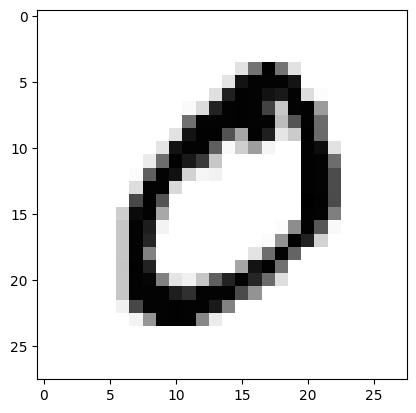

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
plt.imshow(X_train[1], cmap = 'Greys')
print(X_train.shape)

### Preprocessing data

The pixels in the source image are within the range [0, 256] we will normalize this range to [-1, 1] in order to treat this information with neural networks.

In [3]:
X_train = X_train/255.0

In [4]:
X_train = np.expand_dims(X_train, axis=3)

In [5]:
X_train[0].shape

(28, 28, 1)

### Generator definition

In [14]:
def create_generator():
  input = Input(shape=(100))

  x=Dense(64, activation='relu', kernel_regularizer=l2(0.001))(input)
  x = Dropout(0.2)(x)
  x=Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
  x = Dropout(0.2)(x)
  x=Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
  x = Dropout(0.2)(x)
  x=Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)

  x=Dense(28*28, activation='tanh')(x)
  output=Reshape((28, 28, 1))(x)

  generator=Model(input, output)

  return generator

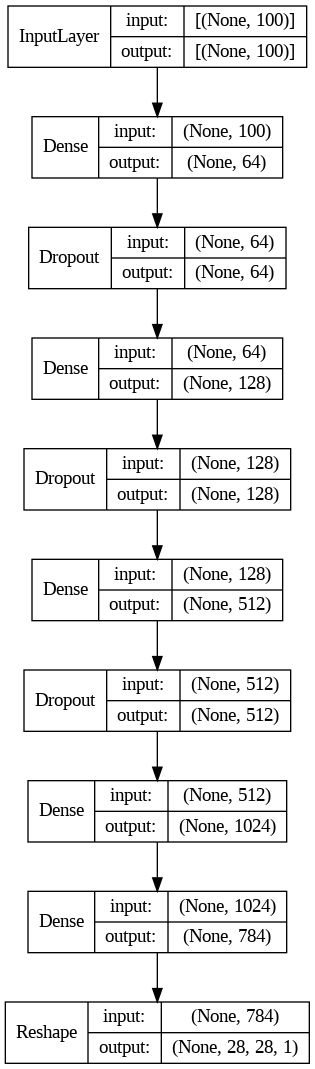

In [15]:
generator=create_generator()
plot_model(generator, show_shapes=True, show_layer_names=False)

### Discriminator definition

In [16]:
def create_discriminator():
  input=Input(shape=(28, 28, 1))

  x=Flatten()(input)

  x=Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
  x=Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
  x = Dropout(0.2)(x)
  x=Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)

  output=Dense(1, activation='sigmoid')(x)

  discriminator=Model(input, output)

  return discriminator

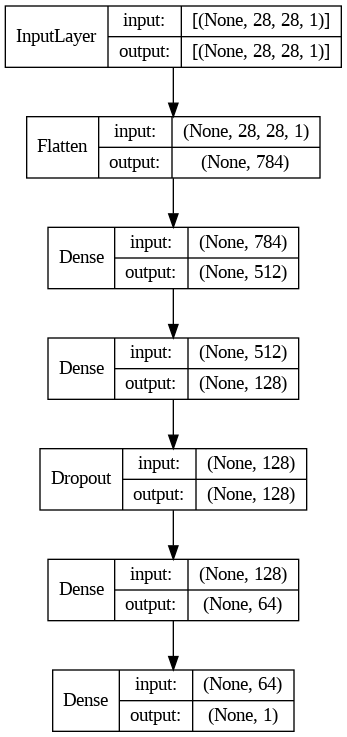

In [17]:
discriminator=create_discriminator()
plot_model(discriminator, show_shapes=True, show_layer_names=False)

### GAN model definition

In [18]:
discriminator.compile(loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable=False

z=Input(shape=(100,))
img=generator(z)
validity=discriminator(img)

combined=Model(z, validity)
from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

### Training

In [19]:
def train(X_train, generator, discriminator, combined, epochs, batch_size=32, sample_interval=100, callbacks=None):
  valid=np.ones((batch_size, 1))
  fake=np.zeros((batch_size, 1))

  for epoch in range(epochs):
    print('Epoch: ', epoch)

    for batch in range(int(len(X_train)/batch_size)):
      #Entreno del discriminador
      noise=np.random.normal(0, 1, (batch_size, 100))
      gen_imgs=generator.predict(noise)
      imgs= X_train[batch*batch_size : (batch+1)*batch_size]

      d_loss_real=discriminator.train_on_batch(imgs, valid)
      d_loss_fake=discriminator.train_on_batch(gen_imgs, fake)

      d_loss=0.5*np.add(d_loss_real, d_loss_fake)

      #Entreno del generator
      noise=np.random.normal(0, 1, (batch_size, 100))
      g_loss=combined.train_on_batch(noise, valid)

      if batch%50==0:
        print('D loss: ', d_loss[0])
        print('D accuracy ', d_loss[1])
        print('G loss: ', g_loss)
        print('\n')

      if batch%sample_interval==0:
        sample_images(gen_imgs, imgs)

    # Llamar a callbacks al final de cada epoch si se proporcionan
    if callbacks is not None:
      for callback in callbacks:
        callback.on_epoch_end(epoch, logs={'D loss': d_loss[0], 'G loss': g_loss})

  # Llamar a callbacks al final del entrenamiento si se proporcionan
  if callbacks is not None:
    for callback in callbacks:
      callback.on_train_end(logs={'final D loss': d_loss[0], 'final G loss': g_loss})

### Plotting functions

In [20]:
def sample_images(gen_imgs, imgs):
  plt.rcParams['figure.figsize']=[15, 5]
  fig, axs=plt.subplots(2, 5)
  for i in range(5):
    axs[0,i].imshow(gen_imgs[i, :, :, 0], cmap='Greys')
    axs[0,i].axis('off')

  for i in range(5):
    axs[1,i].imshow(imgs[i, :, :, 0], cmap='Greys')
    axs[1,i].axis('off')

  plt.show()
  plt.close()

Para que termine de ejecutar hay que pararlo manualmente, pero he conseguido que la precisión y las pérdidas sean más estables, que era el objetivo.

Epoch:  0
1/1 [==============================] - 0s 82ms/step
D loss:  1.5776894688606262
D accuracy  0.46875
G loss:  2.573835611343384




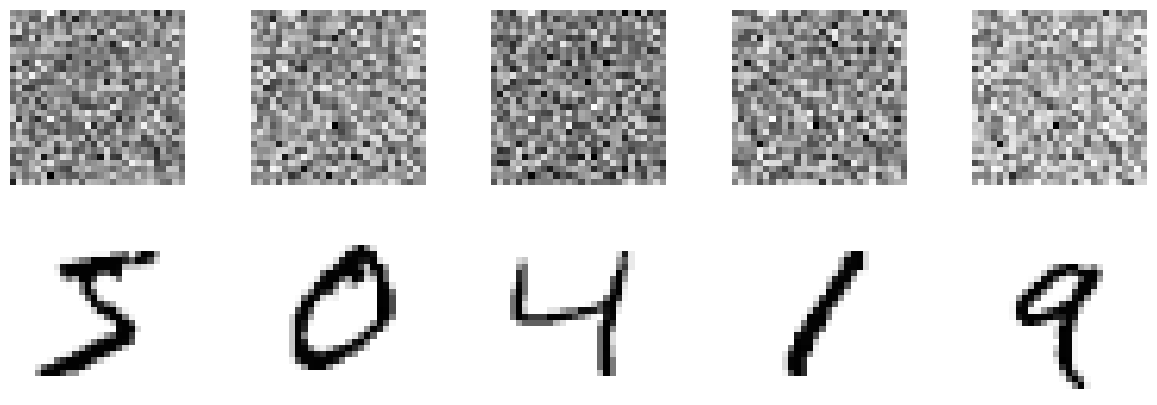

1/1 [==============================] - 0s 17ms/step
D loss:  4.121521472930908
D accuracy  0.375
G loss:  1.8041045665740967


1/1 [==============================] - 0s 27ms/step
D loss:  4.803431391716003
D accuracy  0.375
G loss:  1.6339088678359985




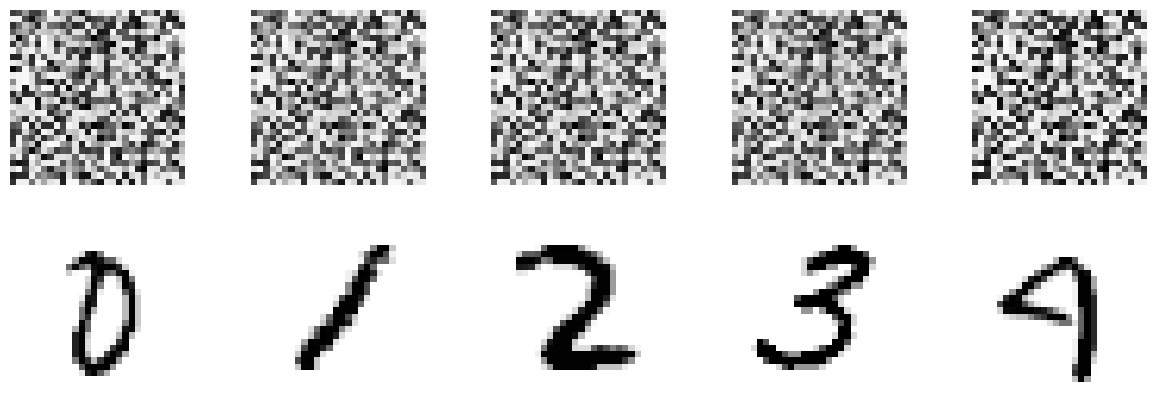

1/1 [==============================] - 0s 29ms/step
D loss:  4.857037305831909
D accuracy  0.46875
G loss:  1.4908103942871094


1/1 [==============================] - 0s 23ms/step
D loss:  5.427350640296936
D accuracy  0.375
G loss:  1.3735709190368652




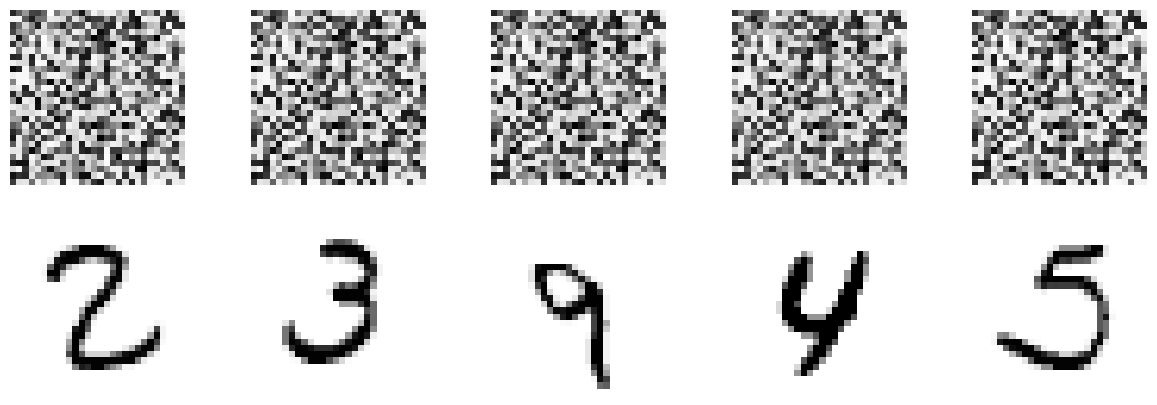

1/1 [==============================] - 0s 21ms/step
D loss:  5.246076464653015
D accuracy  0.4375
G loss:  1.2816121578216553


1/1 [==============================] - 0s 34ms/step


KeyboardInterrupt: ignored

In [21]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Agregar al entrenamiento
callbacks = [
    ModelCheckpoint('gan_model.h5', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

# Luego, al entrenar
train(X_train, generator, discriminator, combined , epochs=10, batch_size=16, callbacks=callbacks)